In [1]:
%matplotlib notebook
from numpy import *
from qutip import *
from typing import Tuple
import matplotlib.pyplot as plt
from scipy.special import gamma as gamma_func
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from time import time 

from basics import *
from hybrid_matrix_elements import *
from atomic_physics import *
from utility import RydStateFS, expand_basis_z, matrix_print

In [2]:
def poisson(x,mu,a=1):
    """
    poisson distribution scaled by a. When a = 1 distribution is normalized
    args:
    x - number of events
    mu - mean number of events
    a - scaling factor, default = 1
    """
    return a*exp(-mu)*mu**x/gamma_func(x+1)

def branching_ratio(mfp,mf):
    """
    Find branching ratio for decay from state |5D5/2,fp,mfp> and |6S1/2,f,mf> assuming only decay channel is through states |6P1/2,5,mpp>
    """
    if abs(mf - mfp) > 2:  # max change in m of 2
        return 0
    if abs(mfp) > fp or abs(mf) > f:  # deal with bad inputs
        return 0
    fpp = 5
    # allowed intermediate states
    mpps = {mfp-1,mfp,mfp+1}.intersection({mf-1,mf,mf+1})  # find allowed intermediate transitions
    b = 0
    for mpp in mpps:
        q = mfp-mpp
        cg1 = clebsch_gordan(1,fpp,fp,q,mpp,mfp)
        #print(cg1)
        q = mpp-mf
        cg2 = clebsch_gordan(1,f,fpp,q,mf,mpp)
        #print(cg2)
        b += (cg1*cg2)**2
    return float(b)

def lorentz(x,FWHM,a):
    return 0.5*a*FWHM/pi/(x**2+FWHM**2)

In [3]:
# experiment parameters
gamma = gamma_5D
l = 685e-9
nu = freq(l)
k = 2*pi/l
P = 100e-3  # W
w0 = 9e-6  # m
scaling = 1.0 # Intensity scaling factor. Range [0,1]
E = electric_field_strength(P,w0)*sqrt(scaling)
rme = q_rme_hf_h(q_rad_int,6)
kpol = SphericalVector([1,0,0],spherical_basis=False)
qpol = SphericalVector([1,0,0],spherical_basis=True)

## constants
gamma = gamma_5D
f=4
fp = 6
U0 = kb*0.6e-3  # 0.6mK deep trap
w0t = 2.5e-6  # FORT waist, 2.5um

## chop timings
fort_on=3.0e-6
tr = 1.2e-6
buff = 0.7e-6
T = fort_on+tr+buff  # chopping period

# Estimate Scattering

Here we estimate the number of spontaneous emission events during a 685nm pulse sequence

The pulse timing is such that the pulse period (T) is smaller than the lifetime of the 5D5/2 states. Similarly the Beam intensity is FAR above saturation. A simplifying assumption is made, that the rabi oscillations and chopping based dynamics can be neglected, these dynamics are time-averaged over, so the atom is assumed to have a $\rho_{ee}$ of about half it's rabi-oscillation based max. Detuning is approximated using a lorentzian.

In [4]:
Qrms_squared = 0
# assume unpolarized atoms initially, average over all rabi-frequencies
for m in range(-f,f+1):
    for mp in range(-fp,fp+1):
        Qrms_squared += abs(
            quadrupole_rabi_frequency(E,nu,qpol,kpol,rme,6,mp,4,m)
        )**2
        print(sqrt(Qrms_squared)/2/pi*1e-6)
Qrms = sqrt(Qrms_squared)# /sqrt((2*f+1)*(2*fp+1))
print(Qrms/2/pi*1e-6)

Omega = abs(Qrms)/2/pi  # convert to frequency from radial frequency
Delta = linspace(-100,100,1000)*1e6  # MHz

FWHM = sqrt(Omega**2/2+gamma**2/4)
#print(FWHM*1e-6)
#print(Omega*1e-6)
#print(k)

0.0
18.892254910076932
18.892254910076932
19.4006575071638
19.4006575071638
19.4006575071638
19.4006575071638
19.4006575071638
19.4006575071638
19.4006575071638
19.4006575071638
19.4006575071638
19.4006575071638
19.4006575071638
19.4006575071638
29.925539955955223
29.925539955955223
31.060558038260776
31.060558038260776
31.060558038260776
31.060558038260776
31.060558038260776
31.060558038260776
31.060558038260776
31.060558038260776
31.060558038260776
31.060558038260776
31.060558038260776
31.060558038260776
38.8570240380118
38.8570240380118
40.758898118382014
40.758898118382014
40.758898118382014
40.758898118382014
40.758898118382014
40.758898118382014
40.758898118382014
40.758898118382014
40.758898118382014
40.758898118382014
40.758898118382014
40.758898118382014
46.32310485895239
46.32310485895239
49.04494121462579
49.04494121462579
49.04494121462579
49.04494121462579
49.04494121462579
49.04494121462579
49.04494121462579
49.04494121462579
49.04494121462579
49.04494121462579
49.0449412

In [5]:
rho_ee = Omega**2/4/(Delta**2+Omega**2/2+gamma**2/4)  # time averaged population in D states
ns_T = T*gamma  # expected photon scattering events, given unit population in D states, during one rydberg chop
Nch = 50  # number of 685-pulse-chops
Nscatts = Nch*ns_T*rho_ee  # expected number of photons scattered during full pulse chain
dE = (hb*k*Nscatts)**2/2/mcs  # change in atom energy from 685 photon scattering
dET = dE/kb*1e3  # change in atom energy in mK

<IPython.core.display.Javascript object>


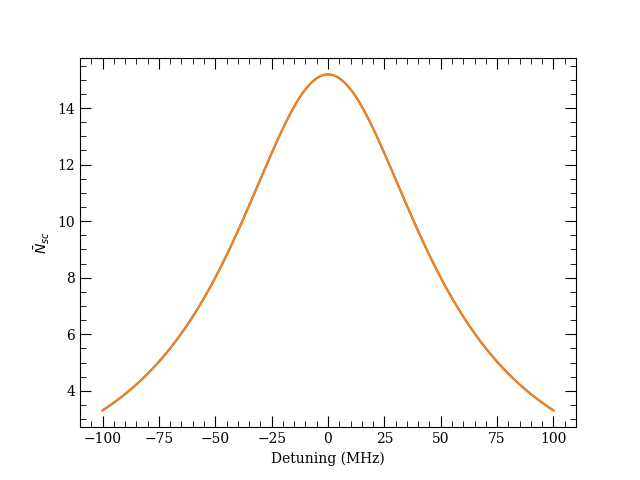

<IPython.core.display.Javascript object>


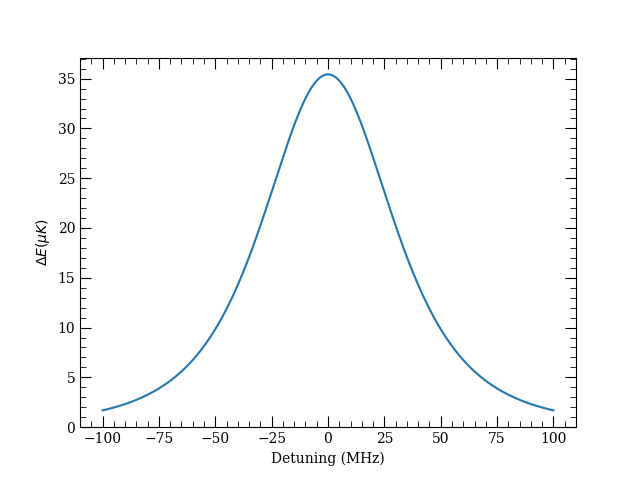

In [8]:
fig,ax=plt.subplots(1,1)
ax.plot(Delta*1e-6,Nscatts)
ax.set_xlabel("Detuning (MHz)")
ax.set_ylabel("$\\bar{N}_{sc}$")

ax.plot(Delta*1e-6,lorentz(Delta,FWHM,max(Nscatts)/lorentz(0,FWHM,1)))
fig.show()

fig,ax=plt.subplots(1,1)
ax.plot(Delta*1e-6,dET*1e3)
ax.set_xlabel("Detuning (MHz)")
ax.set_ylabel("$\Delta E (\mu K)$")

fig.show()

## Look at dist of scattering events, heating rate

Number of scattered photons above are not enough to see boiling out of the trap on average, scattering events have poissonian statistics, so we can check the probability of boiling out of the trap

<IPython.core.display.Javascript object>


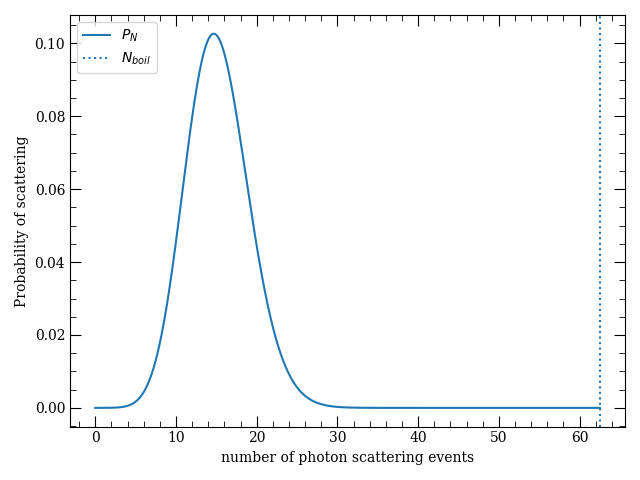

<IPython.core.display.Javascript object>


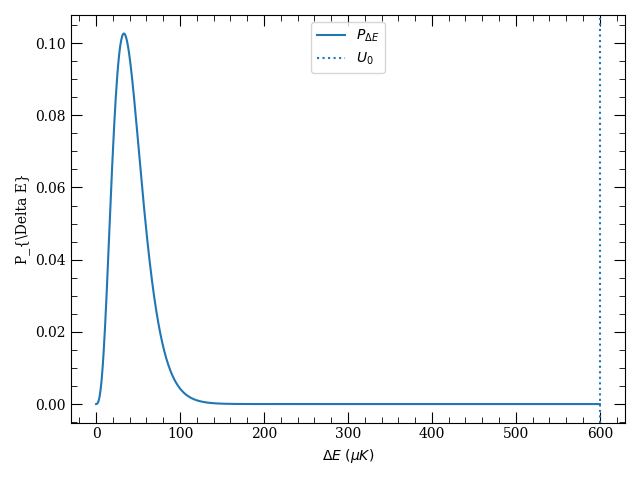

In [9]:
# estimate number of spontaneous decay events over pulse sequence
Nmax = max(Nscatts)  # expected number of 852nm + 3614nm photons spontaneously emitted by cs atom
sig_Nsc = sqrt(Nmax) # photon scattering events are (nearly) poissonian, expect standard deviation to follow poisson statistics
PN = lambda n: poisson(n,Nmax)  # probability distribution of photon scattering events
NE_func = lambda E : sqrt(2*mcs*E)/hb/k
PE = lambda E: PN(NE_func(E))  # probability distribution of atom heating

Nboil = 685e-9*sqrt(2*mcs*U0)/hb/2/pi

fig,ax = plt.subplots(1,1)
ns = linspace(0,Nboil,1000)
ax.plot(ns,PN(ns),label="$P_N$")
ax.set_xlabel("number of photon scattering events")
ax.set_ylabel("Probability of scattering")
ax.axvline(Nboil,ls=":",label="$N_{boil}$")
ax.legend()
fig.tight_layout()
fig.show()

fig,ax = plt.subplots(1,1)
dEs = linspace(0,U0,1000)
ax.plot(dEs/kb*1e6,PE(dEs),label="$P_{\Delta E}$")
ax.set_xlabel("$\Delta E$ $(\mu K)$")
ax.set_ylabel("P_{\Delta E}")
ax.axvline(U0/kb*1e6,ls=":",label="$U_0$")
ax.legend()
fig.tight_layout()
fig.show()

# Resolve Chopping Dynamics

Here a master equation solver is used to see the time-evolution of the atom. The population in the excited state is then numerically integrated to determine the expected number of scattering events

In [10]:
# dimensionality of Hilbert space
f = 4
fp = 6

def get_ind(f,mf):
    if f == 4:
        return mf+4
    else:
        return 4*2+1 + mf+6
dim = 2*f+1 + 2*fp+1  # all zeeman states
natoms = 1000

rho0 = Qobj(diag([1]*(2*f+1)+[0]*(2*fp+1)))/(2*f+1)  # initialize with density matrix that's even statistical mixture of all ground states


Q = zeros((dim,dim),dtype=complex)  # build Quadrupole Rabi operator
decay = zeros(Q.shape,dtype=complex)  # build spontaneous decay operator
for mf in range(-f,f+1):
    for mfp in range(-fp,fp+1):
        Q[get_ind(f,mf),get_ind(fp,mfp)] = quadrupole_rabi_frequency(E,nu,qpol,kpol,rme,f,mf,fp,mfp)  # compute rabi frequency
        Q[get_ind(fp,mfp),get_ind(f,mf)] = Q[get_ind(f,mf),get_ind(fp,mfp)].conjugate()
        
        decay[get_ind(f,mf),get_ind(fp,mfp)] = sqrt(gamma)*branching_ratio(mfp,mf)

Qq = Qobj(Q)
Qdecay = Qobj(decay)
Q_coeff = lambda t, args: (t%T < tr) # *0+1



Ncp = 50
tsh2 = arange(0,T*Ncp,2e-9)
Detunings = linspace(-80,80,100)*1e6*2*pi
Pds = zeros((len(Detunings),len(tsh2)))
Pgs = zeros(Pds.shape)


# solve when \Delta=0
Delta = 0
H0 = Qobj(diag([0]*(2*f+1)+[Delta]*(2*fp+1)))  # unpertubed RWA hamiltonian
H = [H0,[Qq,Q_coeff]]
schsol2 = mesolve(H,rho0,tsh2,Qdecay,[],progress_bar=True)
Pd2 = expect(Qobj(diag([0]*(2*f+1)+[1]*(2*fp+1))),schsol2.states)
Pg2 = expect(Qobj(diag([1]*(2*f+1)+[0]*(2*fp+1))),schsol2.states)

10.0%. Run time:   1.05s. Est. time left: 00:00:00:09
20.0%. Run time:   2.09s. Est. time left: 00:00:00:08
30.0%. Run time:   3.12s. Est. time left: 00:00:00:07
40.0%. Run time:   4.19s. Est. time left: 00:00:00:06
50.0%. Run time:   5.22s. Est. time left: 00:00:00:05
60.0%. Run time:   6.20s. Est. time left: 00:00:00:04
70.0%. Run time:   7.38s. Est. time left: 00:00:00:03
80.0%. Run time:   8.48s. Est. time left: 00:00:00:02
90.0%. Run time:   9.17s. Est. time left: 00:00:00:01
Total run time:  10.19s


<IPython.core.display.Javascript object>


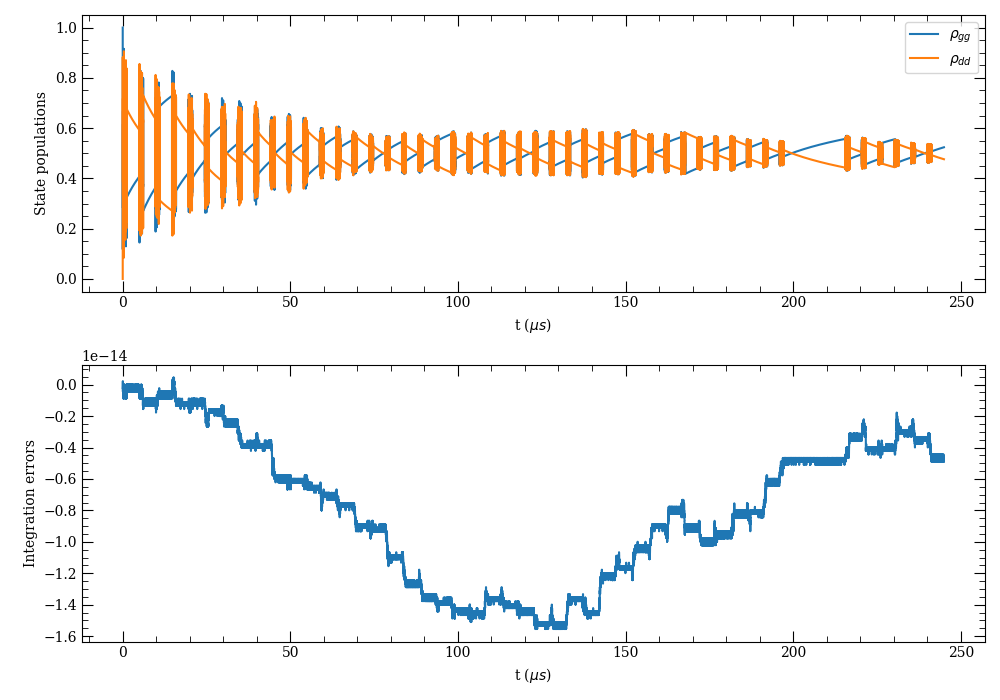

In [11]:
fig,axar = plt.subplots(2,1,figsize=(10,7))
ax = axar[0]
ax.plot(tsh2*1e6,Pg2,label="$\\rho_{gg}$")
ax.plot(tsh2*1e6,Pd2,label="$\\rho_{dd}$")
# ax.plot(tsh2*1e6,0.5*(1+exp(-gamma*tsh2/sqrt(2))),label="decay envelope")
ax.legend()
ax.set_xlabel("t ($\mu s$)")
ax.set_ylabel("State populations")

ax=axar[1]
ax.plot(tsh2*1e6,1-(Pg2+Pd2))
ax.set_ylabel("Integration errors")
ax.set_xlabel("t ($\mu s$)")
fig.tight_layout()
fig.show()

In [12]:
for i, delta in enumerate(Detunings):
    H0 = Qobj(diag([0]*(2*f+1)+[delta]*(2*fp+1)))  # unpertubed RWA hamiltonian
    H = [H0,[Qq,Q_coeff]]

    print(f"detuning = {delta/2/pi*1e-6}MHz")
    schsol2 = mesolve(H,rho0,tsh2,Qdecay,[],progress_bar=True)
    Pds[i] = expect(Qobj(diag([0]*(2*f+1)+[1]*(2*fp+1))),schsol2.states)
    Pgs[i] = expect(Qobj(diag([1]*(2*f+1)+[0]*(2*fp+1))),schsol2.states)

detuning = -80.0MHz
10.0%. Run time:   4.74s. Est. time left: 00:00:00:42
20.0%. Run time:   8.68s. Est. time left: 00:00:00:34
30.0%. Run time:  12.79s. Est. time left: 00:00:00:29
40.0%. Run time:  17.72s. Est. time left: 00:00:00:26
50.0%. Run time:  21.68s. Est. time left: 00:00:00:21
60.0%. Run time:  26.69s. Est. time left: 00:00:00:17
70.0%. Run time:  31.32s. Est. time left: 00:00:00:13
80.0%. Run time:  35.53s. Est. time left: 00:00:00:08
90.0%. Run time:  39.54s. Est. time left: 00:00:00:04
Total run time:  43.83s
detuning = -78.38383838383838MHz
10.0%. Run time:   4.08s. Est. time left: 00:00:00:36
20.0%. Run time:   8.03s. Est. time left: 00:00:00:32
30.0%. Run time:  12.09s. Est. time left: 00:00:00:28
40.0%. Run time:  15.92s. Est. time left: 00:00:00:23
50.0%. Run time:  20.19s. Est. time left: 00:00:00:20
60.0%. Run time:  24.11s. Est. time left: 00:00:00:16
70.0%. Run time:  28.33s. Est. time left: 00:00:00:12
80.0%. Run time:  32.38s. Est. time left: 00:00:00:08
90.0%

20.0%. Run time:   6.15s. Est. time left: 00:00:00:24
30.0%. Run time:   9.62s. Est. time left: 00:00:00:22
40.0%. Run time:  12.90s. Est. time left: 00:00:00:19
50.0%. Run time:  16.08s. Est. time left: 00:00:00:16
60.0%. Run time:  19.28s. Est. time left: 00:00:00:12
70.0%. Run time:  22.18s. Est. time left: 00:00:00:09
80.0%. Run time:  26.05s. Est. time left: 00:00:00:06
90.0%. Run time:  29.65s. Est. time left: 00:00:00:03
Total run time:  32.89s
detuning = -54.141414141414145MHz
10.0%. Run time:   2.97s. Est. time left: 00:00:00:26
20.0%. Run time:   6.26s. Est. time left: 00:00:00:25
30.0%. Run time:   9.52s. Est. time left: 00:00:00:22
40.0%. Run time:  12.71s. Est. time left: 00:00:00:19
50.0%. Run time:  16.00s. Est. time left: 00:00:00:15
60.0%. Run time:  19.33s. Est. time left: 00:00:00:12
70.0%. Run time:  22.58s. Est. time left: 00:00:00:09
80.0%. Run time:  25.93s. Est. time left: 00:00:00:06
90.0%. Run time:  29.74s. Est. time left: 00:00:00:03
Total run time:  32.94s


30.0%. Run time:   7.09s. Est. time left: 00:00:00:16
40.0%. Run time:   9.50s. Est. time left: 00:00:00:14
50.0%. Run time:  11.84s. Est. time left: 00:00:00:11
60.0%. Run time:  14.07s. Est. time left: 00:00:00:09
70.0%. Run time:  16.39s. Est. time left: 00:00:00:07
80.0%. Run time:  18.83s. Est. time left: 00:00:00:04
90.0%. Run time:  21.20s. Est. time left: 00:00:00:02
Total run time:  23.69s
detuning = -29.8989898989899MHz
10.0%. Run time:   2.25s. Est. time left: 00:00:00:20
20.0%. Run time:   4.42s. Est. time left: 00:00:00:17
30.0%. Run time:   6.66s. Est. time left: 00:00:00:15
40.0%. Run time:   9.08s. Est. time left: 00:00:00:13
50.0%. Run time:  11.49s. Est. time left: 00:00:00:11
60.0%. Run time:  13.60s. Est. time left: 00:00:00:09
70.0%. Run time:  16.08s. Est. time left: 00:00:00:06
80.0%. Run time:  18.24s. Est. time left: 00:00:00:04
90.0%. Run time:  20.31s. Est. time left: 00:00:00:02
Total run time:  22.80s
detuning = -28.282828282828284MHz
10.0%. Run time:   2.1

40.0%. Run time:   5.50s. Est. time left: 00:00:00:08
50.0%. Run time:   6.96s. Est. time left: 00:00:00:06
60.0%. Run time:   8.27s. Est. time left: 00:00:00:05
70.0%. Run time:   9.70s. Est. time left: 00:00:00:04
80.0%. Run time:  11.18s. Est. time left: 00:00:00:02
90.0%. Run time:  12.75s. Est. time left: 00:00:00:01
Total run time:  14.19s
detuning = -5.65656565656566MHz
10.0%. Run time:   1.24s. Est. time left: 00:00:00:11
20.0%. Run time:   2.60s. Est. time left: 00:00:00:10
30.0%. Run time:   4.02s. Est. time left: 00:00:00:09
40.0%. Run time:   5.33s. Est. time left: 00:00:00:07
50.0%. Run time:   6.63s. Est. time left: 00:00:00:06
60.0%. Run time:   8.21s. Est. time left: 00:00:00:05
70.0%. Run time:   9.63s. Est. time left: 00:00:00:04
80.0%. Run time:  11.11s. Est. time left: 00:00:00:02
90.0%. Run time:  12.49s. Est. time left: 00:00:00:01
Total run time:  14.09s
detuning = -4.0404040404040416MHz
10.0%. Run time:   1.40s. Est. time left: 00:00:00:12
20.0%. Run time:   2.8

50.0%. Run time:   8.92s. Est. time left: 00:00:00:08
60.0%. Run time:  10.77s. Est. time left: 00:00:00:07
70.0%. Run time:  12.60s. Est. time left: 00:00:00:05
80.0%. Run time:  14.33s. Est. time left: 00:00:00:03
90.0%. Run time:  16.25s. Est. time left: 00:00:00:01
Total run time:  18.02s
detuning = 18.585858585858585MHz
10.0%. Run time:   1.73s. Est. time left: 00:00:00:15
20.0%. Run time:   3.49s. Est. time left: 00:00:00:13
30.0%. Run time:   5.22s. Est. time left: 00:00:00:12
40.0%. Run time:   7.02s. Est. time left: 00:00:00:10
50.0%. Run time:   8.80s. Est. time left: 00:00:00:08
60.0%. Run time:  10.53s. Est. time left: 00:00:00:07
70.0%. Run time:  12.39s. Est. time left: 00:00:00:05
80.0%. Run time:  14.36s. Est. time left: 00:00:00:03
90.0%. Run time:  16.08s. Est. time left: 00:00:00:01
Total run time:  17.88s
detuning = 20.202020202020194MHz
10.0%. Run time:   1.74s. Est. time left: 00:00:00:15
20.0%. Run time:   3.56s. Est. time left: 00:00:00:14
30.0%. Run time:   5.3

60.0%. Run time:  16.73s. Est. time left: 00:00:00:11
70.0%. Run time:  20.00s. Est. time left: 00:00:00:08
80.0%. Run time:  22.95s. Est. time left: 00:00:00:05
90.0%. Run time:  26.44s. Est. time left: 00:00:00:02
Total run time:  29.42s
detuning = 42.828282828282816MHz
10.0%. Run time:   2.60s. Est. time left: 00:00:00:23
20.0%. Run time:   5.31s. Est. time left: 00:00:00:21
30.0%. Run time:   8.25s. Est. time left: 00:00:00:19
40.0%. Run time:  10.76s. Est. time left: 00:00:00:16
50.0%. Run time:  13.38s. Est. time left: 00:00:00:13
60.0%. Run time:  16.32s. Est. time left: 00:00:00:10
70.0%. Run time:  19.68s. Est. time left: 00:00:00:08
80.0%. Run time:  22.42s. Est. time left: 00:00:00:05
90.0%. Run time:  25.43s. Est. time left: 00:00:00:02
Total run time:  28.72s
detuning = 44.444444444444436MHz
10.0%. Run time:   2.84s. Est. time left: 00:00:00:25
20.0%. Run time:   5.72s. Est. time left: 00:00:00:22
30.0%. Run time:   8.77s. Est. time left: 00:00:00:20
40.0%. Run time:  11.5

80.0%. Run time:  29.32s. Est. time left: 00:00:00:07
90.0%. Run time:  32.95s. Est. time left: 00:00:00:03
Total run time:  36.69s
detuning = 67.07070707070706MHz
10.0%. Run time:   3.76s. Est. time left: 00:00:00:33
20.0%. Run time:   7.55s. Est. time left: 00:00:00:30
30.0%. Run time:  11.54s. Est. time left: 00:00:00:26
40.0%. Run time:  15.54s. Est. time left: 00:00:00:23
50.0%. Run time:  19.98s. Est. time left: 00:00:00:19
60.0%. Run time:  23.52s. Est. time left: 00:00:00:15
70.0%. Run time:  27.43s. Est. time left: 00:00:00:11
80.0%. Run time:  31.28s. Est. time left: 00:00:00:07
90.0%. Run time:  34.79s. Est. time left: 00:00:00:03
Total run time:  38.62s
detuning = 68.68686868686868MHz
10.0%. Run time:   4.37s. Est. time left: 00:00:00:39
20.0%. Run time:   7.98s. Est. time left: 00:00:00:31
30.0%. Run time:  11.57s. Est. time left: 00:00:00:27
40.0%. Run time:  15.70s. Est. time left: 00:00:00:23
50.0%. Run time:  19.16s. Est. time left: 00:00:00:19
60.0%. Run time:  22.65s

<IPython.core.display.Javascript object>


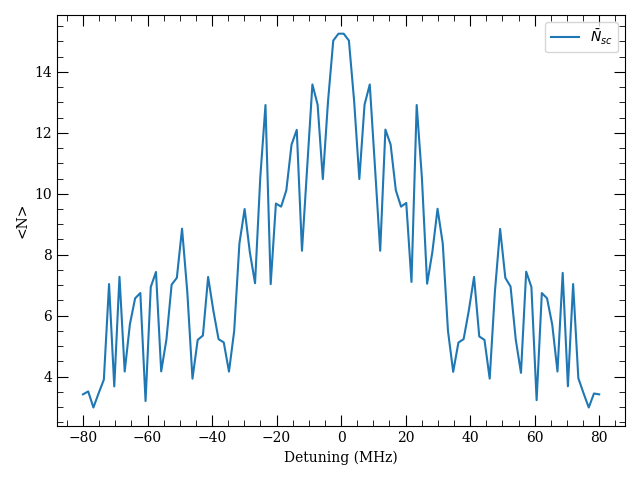

In [13]:
Nboil = 685e-9*sqrt(2*mcs*U0)/hb/2/pi
Nsc = zeros(len(Detunings))

for i, Delta in enumerate(Detunings):
    # estimate number of spontaneous decay events over pulse sequence
    Nsc[i] = trapz(Pds[i],tsh2)*gamma  # expected number of 852nm + 3614nm photons spontaneously emitted by cs atom
    #sig_Nsc = sqrt(Nsc) # photon scattering events are (nearly) poissonian, expect standard deviation to follow poisson statistics
    #PN = lambda n: poisson(n,Nsc)  # probability distribution of photon scattering events
    

fig,ax = plt.subplots(1,1)
ns = linspace(0,Nboil,1000)
ax.plot(Detunings*1e-6/2/pi,Nsc,label="$\\bar{N}_{sc}$")
ax.set_xlabel("Detuning (MHz)")
ax.set_ylabel("<N>")
#ax.axhline(Nboil,ls=":",label="$N_{boil}$")
ax.legend()
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


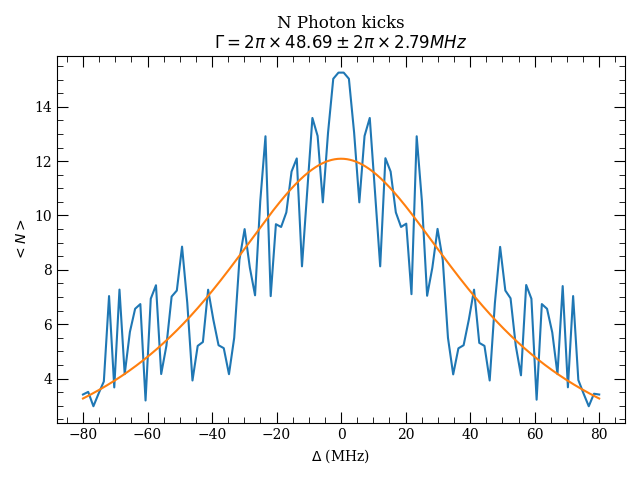

<IPython.core.display.Javascript object>


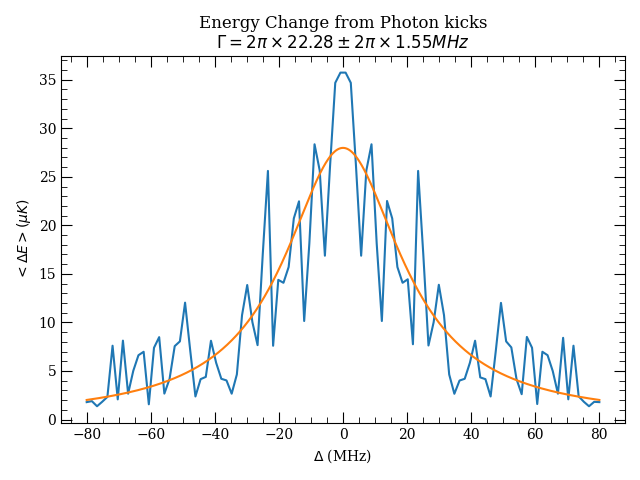

In [14]:
func = lorentz
gammaG = 2*pi*20e6
guess = [gammaG,max(Nsc)/lorentz(0,gammaG,1)]

dE = (hb*k*Nsc)**2/2/mcs  # change in atom energy from 685 photon scattering

xdat = Detunings
ydat = Nsc  # expected scattering events

popt,pcov = curve_fit(func,xdat,ydat,p0=guess)
perr = sqrt(diag(pcov))

xlin = linspace(min(xdat),max(xdat),1000)
fig,ax = plt.subplots(1,1)
ax.plot(xdat*1e-6/2/pi,ydat)
ax.plot(xlin*1e-6/2/pi,func(xlin,*popt))
#ax.plot(xlin*1e-9/2/pi,func(xlin,*guess))
ax.set_xlabel("$\Delta$ (MHz)")
ax.set_ylabel("$<N>$")
ax.set_title(f"N Photon kicks\n$\Gamma = 2\pi \\times {popt[0]*1e-6/2/pi:.2f} \pm 2\pi \\times {perr[0]*1e-6/2/pi:.2f} MHz$")
fig.tight_layout()
fig.show()


ydat = dE/kb*1e6  # energy change in mK

popt,pcov = curve_fit(func,xdat,ydat,p0=guess)
perr = sqrt(diag(pcov))

xlin = linspace(min(xdat),max(xdat),1000)
fig,ax = plt.subplots(1,1)
ax.plot(xdat*1e-6/2/pi,ydat)
ax.plot(xlin*1e-6/2/pi,func(xlin,*popt))
#ax.plot(xlin*1e-9/2/pi,func(xlin,*guess))
ax.set_xlabel("$\Delta$ (MHz)")
ax.set_ylabel("$<\Delta E> (\mu K)$")
ax.set_title(f"Energy Change from Photon kicks\n$\Gamma = 2\pi \\times {popt[0]*1e-6/2/pi:.2f} \pm 2\pi \\times {perr[0]*1e-6/2/pi:.2f} MHz$")
fig.tight_layout()
fig.show()

In [78]:
print(Qrms/2/pi/sqrt(2)*1e-6)

52.76319650647733


# Compute Heating from Anti-Trapping
Clearly the heating from photon scattering isn't enough to cause the atom to leave the trap.

Here we try to model the effects by determining the heating effect of the FORT being on for _FORT_on_ on a finite temperature atom ensemble, if there is anti-trapping ocurring. We try to characterize this as a "heating rate" Q(T) and from the curve extract the probability of atom survival after 50 chops

In [ ]:
# function: fun(t,y), t is time, y is all coordinates
# # y = [x,y,vx,vy]
# # dx/dt,dy/dt = vx, vy
# # dvx/dt, dvy/dt = fx/m,fy/m
def newton_2(t,c,U,w):
    def force(x,y):
        return -4*U/w**2 * exp(-2*(x**2+y**2)/w**2) * array([x,y])/mcs
    return [c[2],c[3],*force(c[0],c[1])]

In [ ]:
def U(x,y):
    return -U0*exp(-2*(x**2+y**2)/w0**2)

Tis = linspace(0,1,100)*U0/kb  # starting ensemble temperatures
Tatom = 100e-6  # atom temperature
zr = pi*w0t**2/938e-9
Uq = U0*(-0.1)  # guess at trap depth (or height) for 5D atoms
Nens = 1000  # size of ensemble

Eis = zeros(len(Tis))
Efs = zeros(Eis.shape)
for i,Ti in enumerate(Tis):
    beta = kb*Ti

    sigv = sqrt(beta/mcs)
    sigx = 0.5*w0t*sqrt(beta/U0)
    sigz = zr*sqrt(2*beta/U0)

    # generate initial conditions
    rnd = random.default_rng()
    xi = rnd.normal(scale=sigx,size=Nens)
    yi = rnd.normal(scale=sigx,size=Nens)
    zi = rnd.normal(scale=sigz,size=Nens)
    vxi = rnd.normal(scale=sigv,size=Nens)
    vyi = rnd.normal(scale=sigv,size=Nens)
    vzi = rnd.normal(scale=sigv,size=Nens)

    # evolve
    ## just x-y for now
    ts = [0,fort_on]
    t = linspace(ts[0],ts[1],100)
    args = [Uq,w0t]
    xs = zeros((Nens,len(t)))
    ys = zeros(xs.shape)
    zs = zeros(xs.shape)
    vxs = zeros(xs.shape)
    vys = zeros(xs.shape)
    vzs = zeros(xs.shape)
    start = time()
    for n in range(Nens):
        y0 = [xi[n],yi[n],vxi[n],vyi[n]]
        sol = solve_ivp(newton_2,ts,y0=y0,method="Radau",t_eval=t,args=args)
        xs[n],ys[n],vxs[n],vys[n] = sol["y"]
    print(f"integration time = {time()-start}s")
    
    E = U(xs,ys) + 0.5*mcs*(vxs**2+vys**2)
    Eis[i] = E[:,0].mean()
    Efs[i] = E[:,-1].mean()

In [ ]:
fig,ax=plt.subplots(1,1)
ax.plot(Tis*1e6,(Eis+U0)/kb*1e6,label="$E_i$")
ax.plot(Tis*1e6,(Efs+U0)/kb*1e6,label="$E_f$")
ax.legend()
ax.set_xlabel("$T_i$ ($\mu K$)")
ax.set_ylabel("$E$ ($\mu K$)")
fig.show()

fig,ax=plt.subplots(1,1)
ax.plot(Tis*1e6,(Efs-Eis)/kb*1e6,label="$E_i$")
ax.set_xlabel("$T_i$ ($\mu K$)")
ax.set_ylabel("$\Delta E$ ($\mu K$)")
fig.show()

In [ ]:
dEs = (Efs-Eis)/kb*1e6

func = lambda x,m : m*x
guess = [14/600]

popt,pcov = curve_fit(func,Tis*1e6,dEs,p0=guess)
perr = sqrt(diag(pcov))

fig,ax=plt.subplots(1,1)
ax.plot(Tis*1e6,dEs,".",label="raw")
ax.plot(Tis*1e6,func(Tis*1e6,*popt),label="fit")
ax.set_title(f"c={popt[0]:.4f}$\pm${perr[0]:.5f}")
fig.show()

In [ ]:
c = popt[0]

Estart = 15  # uK
chop_E = Estart*(c*(c**Nch-1)+Nch*(1-c))/(c-1)**2
print(chop_E)
U0uk = U0/kb*1e6
retention = 1-exp(-U0uk/chop_E)
print(retention)

In [ ]:
def U(x,y):
    return -U0*exp(-2*(x**2+y**2)/w0**2)
E = U(xs,ys) + 0.5*mcs*(vxs**2+vys**2)

Ei = E[:,0]
Ef = E[:,-1]
fig,ax=plt.subplots(1,1)
ax.hist((Ef+U0)/kb*1e6,histtype="step",label="Ef")
ax.hist((E[:,0]+U0)/kb*1e6,histtype="step",label="Ef")
hx = linspace(*ax.get_xlim(),1000)
#ax.plot(hx,500*exp(-hx/mean((Ef+U0)/kb*1e6)) )
ax.set_xlabel("Atom Energies (uK)")
ax.set_ylabel("Events")
ax.set_title(f"$<\Delta E> = {(mean(Ef)-mean(Ei))/kb*1e6:.1f}\mu k$")
fig.show()

In [ ]:
hx = linspace(*ax.get_xlim(),1000)
hx

In [ ]:
ax.get_xlim()

In [ ]:
fig,ax = plt.subplots(1,1)
for n in range(Nens):
    ax.plot(xs[n]/w0t,ys[n]/w0t)
ax.set_xlabel("x position (w0)")
ax.set_ylabel("y position (w0)")
fig.tight_layout()
fig.show()
fig,ax = plt.subplots(1,1)
for n in range(Nens):
    ax.plot(t*1e6,xs[n]/w0)
fig.show()

def U(x,y):
    return -U0*exp(-2*(x**2+y**2)/w0**2)
E = U(xs,ys) + 0.5*mcs*(vxs**2+vys**2)
fig,ax = plt.subplots(1,1)
for n in range(Nens):
    ax.plot(t*1e6,1e3*(E[n]+U0)/kb)
ax.set_ylabel("Atom Energy (mK)")
ax.set_xlabel("Time ($\mu s$)")
fig.show()
fig,ax = plt.subplots(1,1)
for n in range(Nens):
    ax.plot(t*1e6,(E[n]-E[n,0])/E[0])
ax.set_ylabel("Atom Energy (mK)")
ax.set_xlabel("Time ($\mu s$)")
fig.show()

In [ ]:
help(ax.hist)

In [ ]:
t=0
w0 = 2.6e-6  # 2.6 um
U0 = kb*0.6e-3  # 0.6 mK
Uq = -U0/10  # rough trap depth estimate for 5D atoms

args = [Uq,w0]

ts = [0,fort_on]
t = linspace(max(ts[0],ts[1]-3e-3),ts[1],1000)
sol = solve_ivp(newton_2,ts,y0=[w0/10,0.01*w0,0.2,0],method="Radau",t_eval=t,args = args)

sy = sol["y"]
xs,ys,vxs,vys = sy